In [69]:
import json 
import pandas as pd
import numpy as np 
import geopy.distance

#package for flattening json in pandas df
from pandas.io.json import json_normalize

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [71]:
output_parsed_data_filename = '../input/parsed_data.csv'

calc_last_5_games = True
use_team_hot_encoding = False
use_team_home_away_hot_encoding = False

games = pd.read_csv(output_parsed_data_filename)
games = games.drop(['Unnamed: 0'], axis=1)

/Users/jkentjnr/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
statsColumns = pd.Series(list(games.columns.values))
statsColumns = statsColumns.loc[statsColumns.str.startswith(('statsAway', 'statsHome'), na=False)]

In [73]:
# Replace any NaN with 0 in the stats
games[statsColumns] = games[statsColumns].fillna(value=-12)

In [74]:
#games['season'] = games['season'].astype('float')
games['scoreAway'] = games['scoreAway'].astype('uint8')
games['scoreHome'] = games['scoreHome'].astype('uint8')

games['statsHome.FgAtt'] = games['statsHome.FgAtt'].astype('uint8')
games['statsHome.OffReb'] = games['statsHome.OffReb'].astype('uint8')
games['statsHome.Tov'] = games['statsHome.Tov'].astype('uint8')
games['statsHome.FtAtt'] = games['statsHome.FtAtt'].astype('uint8')
games['statsHome.Pts'] = games['statsHome.Pts'].astype('uint8')

games['statsAway.FgAtt'] = games['statsAway.FgAtt'].astype('uint8')
games['statsAway.OffReb'] = games['statsAway.OffReb'].astype('uint8')
games['statsAway.Tov'] = games['statsAway.Tov'].astype('uint8')
games['statsAway.FtAtt'] = games['statsAway.FtAtt'].astype('uint8')
games['statsAway.Pts'] = games['statsAway.Pts'].astype('uint8')

#scoreQuarters          object
#teamAwayCode           object

In [75]:
games["time"] = pd.to_datetime(games["time"])

In [76]:
if use_team_hot_encoding == True:
    homeTeam = pd.get_dummies(games["teamHomeCode"], prefix='team')
    awayTeam = pd.get_dummies(games["teamAwayCode"], prefix='team')

    homeTeam = homeTeam.replace({0:np.nan})
    awayTeam = awayTeam.replace({0:np.nan})

    teams = homeTeam.fillna(awayTeam).fillna(0).astype('bool')
    # teams[['team_NYK', 'team_CLE', 'team_ATL', 'team_BOS']].head(2)
    
    games = pd.concat([games, teams], axis=1)
    
    games[['teamHomeCode', 'teamAwayCode', 'team_NYK', 'team_CLE']].head(2)

In [77]:
if use_team_home_away_hot_encoding == True:
    homeTeam = pd.get_dummies(games["teamHomeCode"], prefix='hometeam').astype('bool')
    awayTeam = pd.get_dummies(games["teamAwayCode"], prefix='awayteam').astype('bool')

    games = pd.concat([games, homeTeam, awayTeam], axis=1)
    
    games[['teamHomeCode', 'teamAwayCode', 'hometeam_NYK', 'hometeam_CLE', 'awayteam_NYK', 'awayteam_CLE']].head(2)

In [78]:
games = games.drop(["teamAwayCode", "teamHomeCode"], axis=1)

In [79]:
games = games.drop(["location", "scoreQuarters", "time"], axis=1)

In [80]:
games = games.drop(statsColumns, axis=1)

In [81]:
games["homeWin"] = games["scoreHome"] > games["scoreAway"]

In [82]:
games = games.drop(["scoreAway", "scoreHome"], axis=1)

In [83]:
# Remove any games that have less than a 5 game history.
if calc_last_5_games == True:
    games = games[(pd.notnull(games['lastGame1WinHome'])) & (pd.notnull(games['lastGame1AtHomeAway']))]

In [84]:
games[games.isnull().T.any().T]

,id,oddsBet365Away,oddsBet365Home,season,gamesPlayedHome,gamesPlayedAway,totalGamesHome,totalWinsHome,homeGamesHome,homeWinsHome,...,lastGame1AtHomeAway,lastGame2WinAway,lastGame2AtHomeAway,lastGame3WinAway,lastGame3AtHomeAway,lastGame4WinAway,lastGame4AtHomeAway,lastGame5WinAway,lastGame5AtHomeAway,homeWin


In [85]:
#msk = np.random.rand(len(games)) < 0.8
#msk

train = games
#test = games[~msk]

 
temp=train

In [86]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in  train.columns:
    
    if train[col].dtype=='object' or  train[col].dtype=='bool':
        train[col]=le.fit_transform(train[col])

In [87]:
train.head(3)

,id,oddsBet365Away,oddsBet365Home,season,gamesPlayedHome,gamesPlayedAway,totalGamesHome,totalWinsHome,homeGamesHome,homeWinsHome,...,lastGame1AtHomeAway,lastGame2WinAway,lastGame2AtHomeAway,lastGame3WinAway,lastGame3AtHomeAway,lastGame4WinAway,lastGame4AtHomeAway,lastGame5WinAway,lastGame5AtHomeAway,homeWin
0,6608,3.40,1.33,2015,9,3,5,3,3,3,...,1,1,1,1,1,1,1,1,1,0
1,6609,2.30,1.66,2015,82,20,78,38,40,25,...,0,1,0,1,0,0,1,1,0,1
2,6610,5.25,1.18,2015,22,82,28,21,13,11,...,0,0,0,1,0,1,1,1,1,1


In [88]:

Y_train = train["homeWin"]
X_train = train.drop(["id","homeWin"], axis=1)
X=np.array(X_train)
y=np.array(Y_train)

In [89]:
X_train.columns

Index(['oddsBet365Away', 'oddsBet365Home', 'season', 'gamesPlayedHome',
       'gamesPlayedAway', 'totalGamesHome', 'totalWinsHome', 'homeGamesHome',
       'homeWinsHome', 'awayGamesHome', 'awayWinsHome',
       'percentageTotalWinHome', 'percentageHomeWinHome',
       'percentageAwayWinHome', 'totalGamesAway', 'totalWinsAway',
       'homeGamesAway', 'homeWinsAway', 'awayGamesAway', 'awayWinsAway',
       'percentageTotalWinAway', 'percentageHomeWinAway',
       'percentageAwayWinAway', 'lastGame1WinHome', 'lastGame1AtHomeHome',
       'lastGame2WinHome', 'lastGame2AtHomeHome', 'lastGame3WinHome',
       'lastGame3AtHomeHome', 'lastGame4WinHome', 'lastGame4AtHomeHome',
       'lastGame5WinHome', 'lastGame5AtHomeHome', 'lastGame1WinAway',
       'lastGame1AtHomeAway', 'lastGame2WinAway', 'lastGame2AtHomeAway',
       'lastGame3WinAway', 'lastGame3AtHomeAway', 'lastGame4WinAway',
       'lastGame4AtHomeAway', 'lastGame5WinAway', 'lastGame5AtHomeAway'],
      dtype='object')

In [90]:
 
import xgboost  as xgb

In [91]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [92]:
model=xgb.XGBClassifier(n_estimators=250)

In [93]:
model.fit(np.array(X),y)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [94]:
import  matplotlib
from matplotlib  import pyplot as plt


In [96]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


AttributeError: Unknown property max_num_features

In [97]:
 ##########################################Checking accuracy  on  5 cross   validations###############################

In [98]:
from sklearn.metrics import accuracy_score

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=250)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.682926829268
0.675910457735
0.654193117274
0.663548279318
0.685265619779


In [101]:
np.unique(pred,return_counts=True)

(array([0, 1]), array([1033, 1960]))

In [102]:
from sklearn.ensemble import  RandomForestClassifier
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.677915135316
0.662211827598
0.657868359506
0.661877714668
0.677246909455


Feature ranking:
1. feature 0 (0.087396)
2. feature 1 (0.084876)
3. feature 11 (0.046986)
4. feature 12 (0.044897)
5. feature 20 (0.043814)
6. feature 13 (0.042747)
7. feature 22 (0.042635)
8. feature 21 (0.042217)
9. feature 3 (0.033822)
10. feature 4 (0.032176)
11. feature 5 (0.031063)
12. feature 14 (0.030729)
13. feature 6 (0.030710)
14. feature 15 (0.029799)
15. feature 9 (0.029202)
16. feature 16 (0.028472)
17. feature 18 (0.028378)
18. feature 7 (0.027808)
19. feature 17 (0.026934)
20. feature 10 (0.026852)
21. feature 19 (0.026270)
22. feature 8 (0.026091)
23. feature 2 (0.021437)
24. feature 35 (0.007058)
25. feature 42 (0.007034)
26. feature 34 (0.007029)
27. feature 30 (0.006988)
28. feature 31 (0.006954)
29. feature 36 (0.006951)
30. feature 41 (0.006901)
31. feature 38 (0.006864)
32. feature 28 (0.006851)
33. feature 29 (0.006791)
34. feature 40 (0.006788)
35. feature 26 (0.006743)
36. feature 27 (0.006640)
37. feature 24 (0.006534)
38. feature 25 (0.006521)
39. feature 23

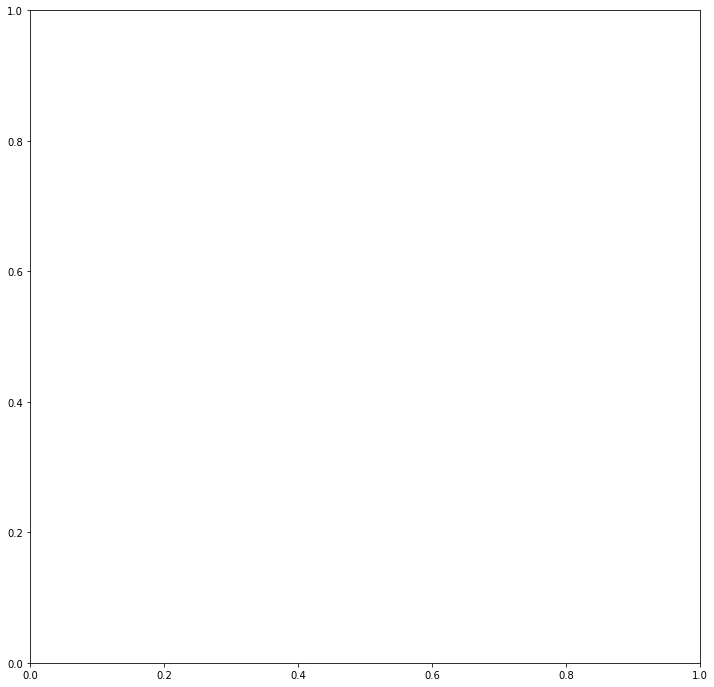

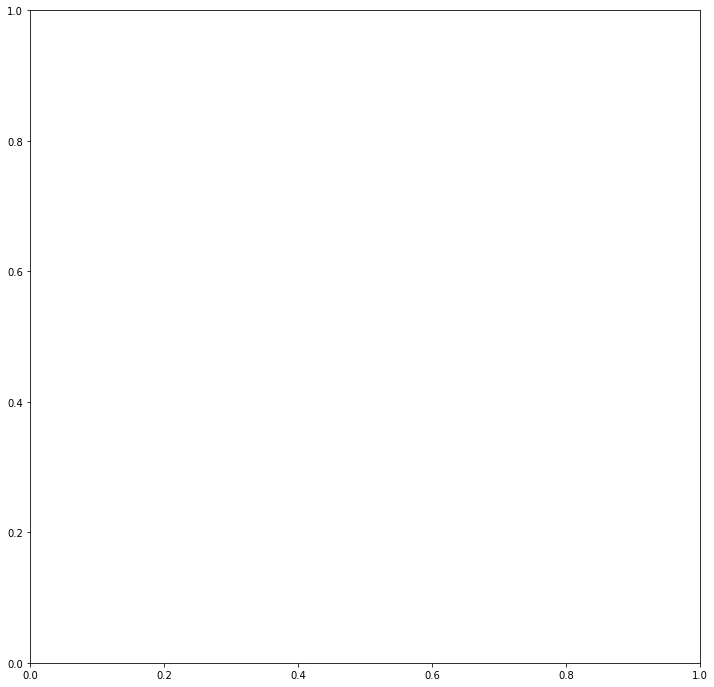

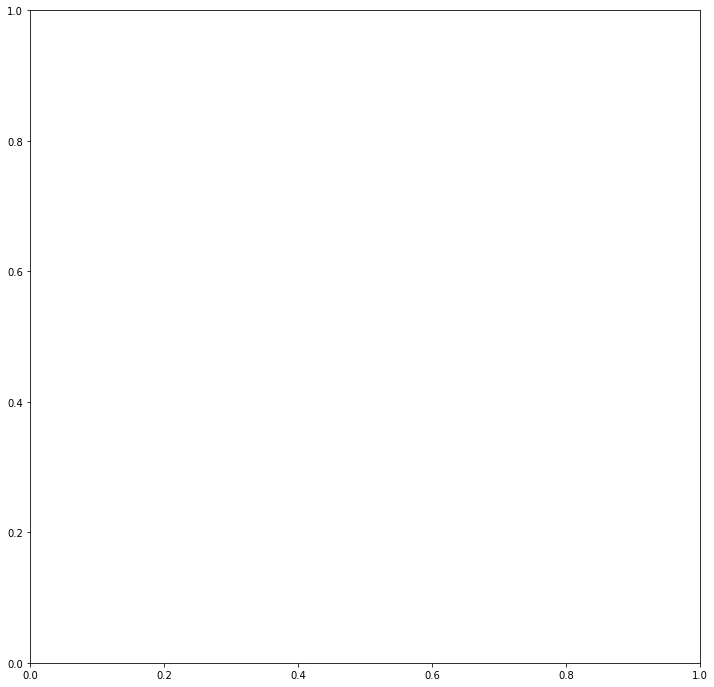

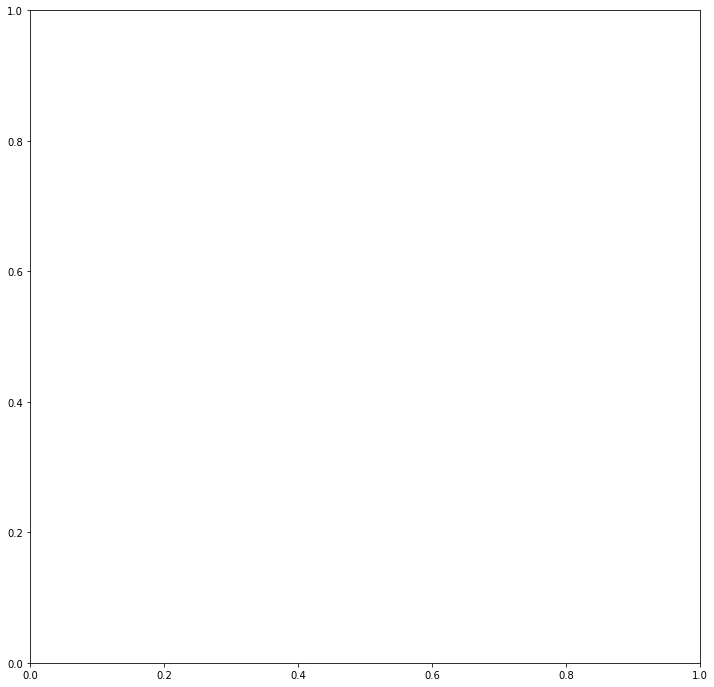

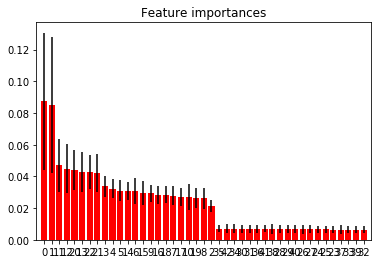

In [103]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [104]:
import numpy as np
import GPy
import GPyOpt
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score
y=y.astype(int)

In [105]:

def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                XGBClassifier(learning_rate=parameters[0],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              gamma=int(parameters[1]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='accuracy').mean()
    score = np.array(score)
    return score
baseline = -cross_val_score(XGBClassifier(), X, y, scoring='accuracy').mean()
baseline

-0.6788712816418343

In [106]:
bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5, 1)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (1e-5, 5)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 1000)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
         ]

np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

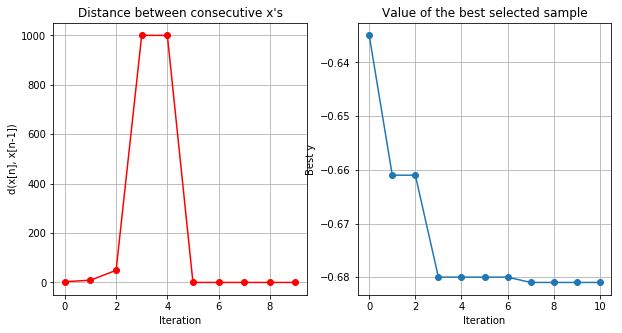

In [107]:

optimizer.plot_convergence()

In [108]:
np.set_printoptions(suppress=True)
optimizer.X[np.argmin(optimizer.Y)]

array([    0.38023664,     1.94820821,     1.        ,  1000.        ,
           1.        ])

In [109]:
np.min(optimizer.Y)

-0.68096633071008883

In [110]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.659873037087
0.651186100902
0.643835616438
0.641162712997
0.660541262947


In [111]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


AttributeError: Unknown property max_num_features

In [ ]:
########################################Adding  new features ############################################################

In [ ]:
X

In [ ]:
###########################################correlation###################################################################

In [ ]:
np.corrcoef(X)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
new_train=pca.fit_transform(X)

In [ ]:
np.corrcoef(new_train)

In [ ]:
temp_train1=np.hstack((new_train,X))

In [ ]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(temp_train1, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=10, n_iter=1000, random_state=42)

In [ ]:
new_train=svd.fit_transform(X)

In [ ]:
np.corrcoef(new_train)

In [ ]:
temp_train2=np.hstack((new_train,temp_train1))

In [ ]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(temp_train2, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
new_train = TSNE(n_components=3).fit_transform(X)

In [ ]:
new_train.shape

In [ ]:
np.corrcoef(new_train[:,0],new_train[:,2])

In [ ]:
temp_train3=np.hstack((new_train,X))

In [ ]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(temp_train3, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     

In [ ]:
from sklearn.ensemble import  RandomForestClassifier
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(temp_train3, y, test_size=0.33, random_state=cross)
    model=RandomForestClassifier(n_estimators=500)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

In [ ]:
one_hot_encoded_training_predictors = pd.get_dummies(temp)

In [ ]:
one_hot_encoded_training_predictors.shape

In [ ]:
big_train=one_hot_encoded_training_predictors

In [ ]:
big_train= big_train.drop(["id","homeWin"], axis=1)

In [ ]:
big_train.shape

In [ ]:
#for cross  in range(5):
#    X_train, X_test, y_train, y_test = train_test_split(big_train, y, test_size=0.2, random_state=cross)
#    model=xgb.XGBClassifier(n_estimators=5000,learning_rate=0.33589572,gamma=4.8989112,
#                           max_depth= 200,min_child_weight=10)
#    model.fit(X_train,y_train)
#    pred=model.predict(X_test)
#    print(accuracy_score(y_test,pred))
    
     

In [ ]:

def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                XGBClassifier(learning_rate=parameters[0],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              gamma=int(parameters[1]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='accuracy').mean()
    score = np.array(score)
    return score
baseline = -cross_val_score(XGBClassifier(), big_train, y, scoring='accuracy').mean()
baseline

In [ ]:
bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5, 1)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (1e-5, 5)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 200)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 5000)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
         ]

np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

In [ ]:
np.min(optimizer.Y)

In [ ]:
np.set_printoptions(suppress=True)
optimizer.X[np.argmin(optimizer.Y)]

In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Convolution1D, Flatten, MaxPooling1D,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
big_train.shape

In [ ]:
 
def create_baseline():
    
    model = Sequential()
    
    model.add(Dense(128, input_dim=624, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
 
    
    model.add(Dropout(0.1))
 
    model.add(Dense(64, kernel_initializer='normal', activation='tanh'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
 
    
    
    
      
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.09))
    
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.15))
    
    
    model.add(Dense(64, kernel_initializer='normal', activation='tanh'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(128, input_dim=624, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
 
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, np.array(big_train), y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
####################################Averaging   first   attempt######################################################

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=cross)

In [ ]:
X.shape

In [ ]:
    model1=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model2=RandomForestClassifier(n_estimators=250)

In [ ]:
    model1.fit(X_train,y_train)

In [ ]:
model2.fit(X_train,y_train)

In [ ]:
pred1=model1.predict_proba(X_test)

In [ ]:
pred2=model2.predict_proba(X_test)

In [ ]:
avg=(pred1+pred2)/2

In [ ]:
from sklearn.metrics  import log_loss
accuracy_score(y_test,np.round(avg[:,1]))

In [ ]:
y=y.reshape(y.shape[0],1)

In [ ]:
damian=big_train

In [ ]:
damian['y']=y

In [ ]:
damian.to_csv('NBA_DATA.csv',index=False)

In [ ]:
big_train=big_train.drop('y',axis=1)